<a href="https://colab.research.google.com/github/joshualewin6/Colab-Notebook/blob/main/JoshLewiU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Football Scores: Modeling the NFL Teams
##Intro
We're back at, modeling the likely scores in an NFL game. This time, we have a few more weeks completed and therefore a bit more data. The key difference, though, is that we are predicting scores for each individual team, and since how one team does is somewhat indicative of how another will do*, we will use hyperpriors to inform our priors. This is extra helpful since each team has only played 8 or 9 games, which on it's own wouldn't be sufficient to model a team.

*It'll generally indicate how good teams are that year and how many points they score, plus, more points for one team means more possessions means more points for the other team.

Alright, we can start by importing our libraries and our data through week 9.

In [1]:
!pip install "preliz[full,notebook]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.2/514.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0


In [2]:
import preliz as pz
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm
import random
import math

In [3]:
nfl_data=pd.read_csv('https://raw.githubusercontent.com/joshualewin6/Colab-Notebook/refs/heads/main/nflGamesThruWeek9.csv',dtype={'Team':'category'})
nfl_data

,Team,Score
0,BAL,20
1,GB,29
2,PIT,18
3,ARI,28
4,TEN,17
...,...,...
271,ARI,29
272,GB,14
273,SEA,20
274,MIN,21


Let's visualize it here with a violin plot. It's going to look a little strange, since we have limited data for each team.

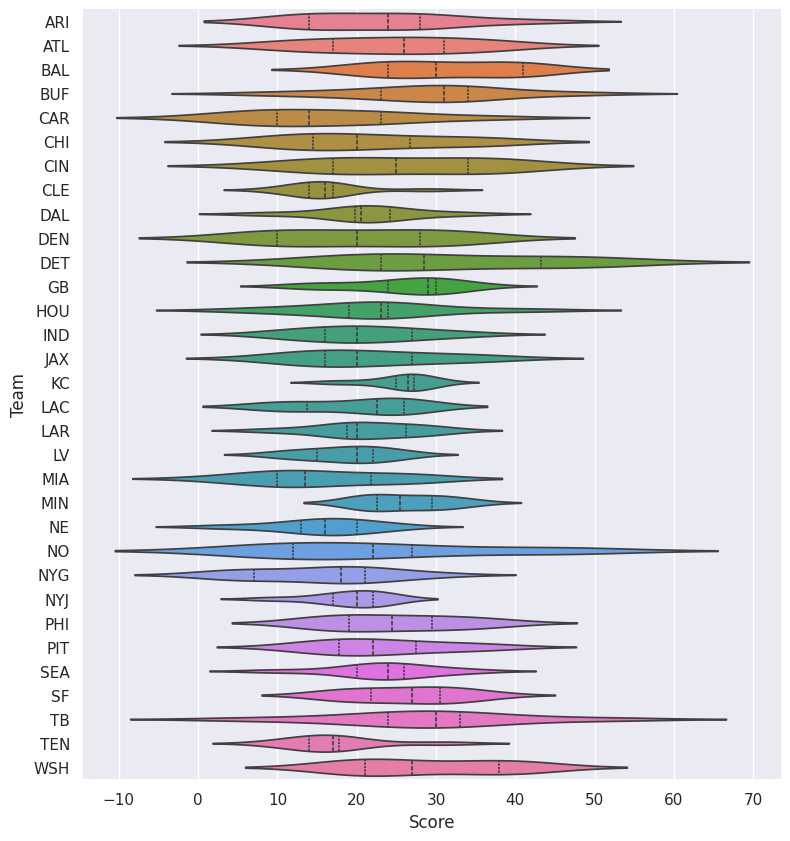

In [4]:
sns.set_theme(rc={'figure.figsize':(9,10)})
sns.violinplot(nfl_data, x='Score', y='Team', inner='quart', hue='Team',width=0.7)
sns.despine(top=True, right=True, bottom=True, left=True)

##The Model
Nice! The data is in place, and now we just need to make the model. In a previous model, I used certain priors to model scores for the NFL as a whole. They looked something like this:

In [5]:
    #90% of values between 20.5 and 24.5 for the mean)
    #μ = pm.Normal('μ', mu=22.5, sigma=1.22)
    #For the standard devation, I don't know what that should really look like, so a simple HalfNormal should suffice, sigma=12 makes the mean about 9.5
    #σ = pm.HalfNormal('σ', sigma=12)

 I can do something similar for the hyperpriors here, but there is an issue. These were for the entire nfl and since it there was so much data for just one category, there didn't need to be much deviation in the means; it was clear it would average out. As you can see, the averages are naturally going to be all over the place, and likewise for individual data points, as these graphs come in all shapes, sizes, and locations.

###The Priors and Hyperpriors
Since the teams are so varied, their means will still be best modeled by a Gamma distribution (since we now must be more careful to exclude 0) still with mean 22.5, but with a bit higher standard deviation to account for the teams having different means; we'll say 3 for now.


The distribution for the standard deviation of their means, we can use another Gamma distribution with mean 7.5, since by eyballing the mean lines, I can see that's probably about their standard deviation. We'll make the standard deviation for this 2, since I'm unsure of what it typically should be, but it can't be that big a deviation, since teams won't be that evenly or unevenly matched in any given season, it stays roughly the same.


As for the team's standard deviations, I'm going with a Half Normal, same as before, for which the hyperprior will be a Gamma distribution with mean 7 and standard deviation 3, so that we sample some Half Normals with reasonable standard deviations and avoid too many crazy outliers.

So, we need to do some sorting so the model can read it, but the hyperpriors and priors will look something like this:

In [6]:
team_encode = pd.Categorical(nfl_data['Team'])

team_idx = team_encode.codes

team_coords = {"Team": team_encode.categories}

team_coords

{'Team': Index(['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN',
        'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LAC', 'LAR', 'LV', 'MIA',
        'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN',
        'WSH'],
       dtype='object')}

In [7]:
 #   μ_mu = pm.Gamma('μ_mu', mu = 22.5, sigma = 3)
 #   μ_sd = pm.Gamma('μ_sd', mu = 7.5, sigma = 2)
 #   σ_sd = pm.Gamma('σ', mu = 7 sigma = 3)
 #

 #   μ = pm.Gamma('μ',
 #                 mu = μ_mu,
 #                 sigma = μ_sd,
 #                 dims = "Team")

 #   σ = pm.HalfNormal('σ', sigma = σ_sd,
 #                 dims = "Team")

### The Likelihood
The likelihood will be a Gamma distribution as well, since that has so far been the most convenient for modeling nfl scores, and so the shape should work similarly well.

With that, we can build our model with all these distributions and samples. It looks like this:

In [8]:
  with pm.Model(coords=team_coords) as nfl_model:

    #hyperpriors
    μ_mu = pm.Gamma('μ_mu', mu = 22.5, sigma = 3)
    μ_sd = pm.Gamma('μ_sd', mu = 7.5, sigma = 2)
    σ_sd = pm.Gamma('σ_sd', mu = 7, sigma = 3)

    #priors
    μ = pm.Gamma('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "Team")

    σ = pm.HalfNormal('σ', sigma = σ_sd,
                  dims = "Team")

    #likelihood
    y = pm.Gamma('y',
                  mu = μ[team_idx],
                  sigma = σ[team_idx],
                  observed = nfl_data.Score)


    idata_nfl = pm.sample()

Output()

Output()

Look at that! No divergences. Now let's visualize what we've found.

##The Analysis
Let's start just by looking at each team's posterior distribution of their means and standard deviations, just to confirm that nothing crazy happened when our model ran.

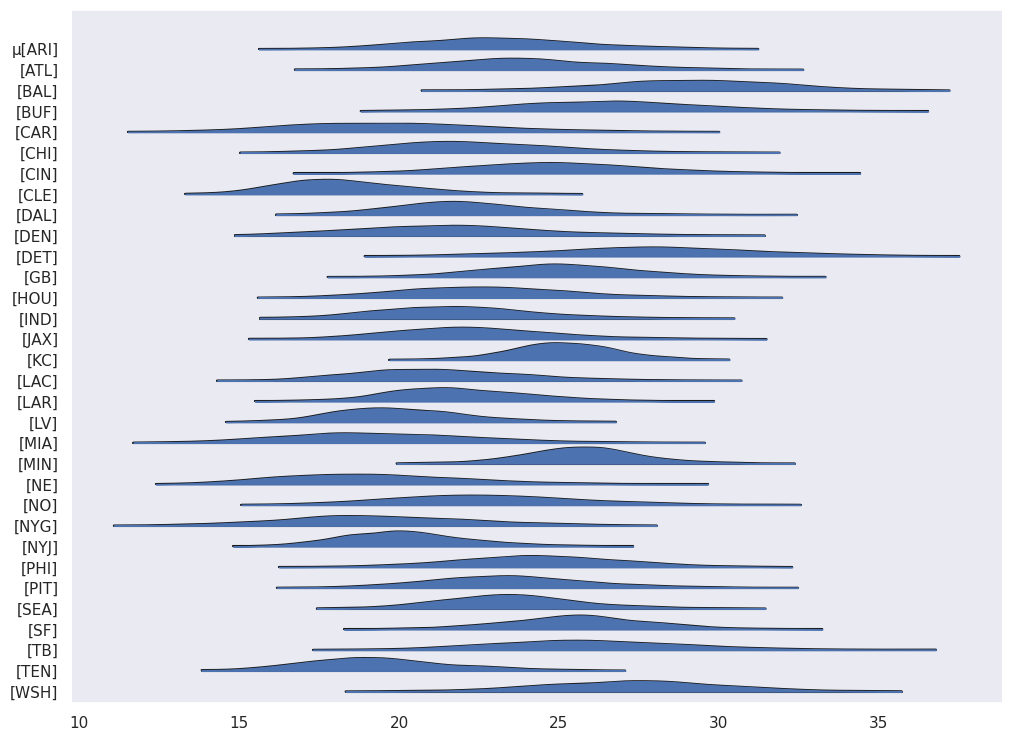

In [9]:
axes = az.plot_forest(idata_nfl, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

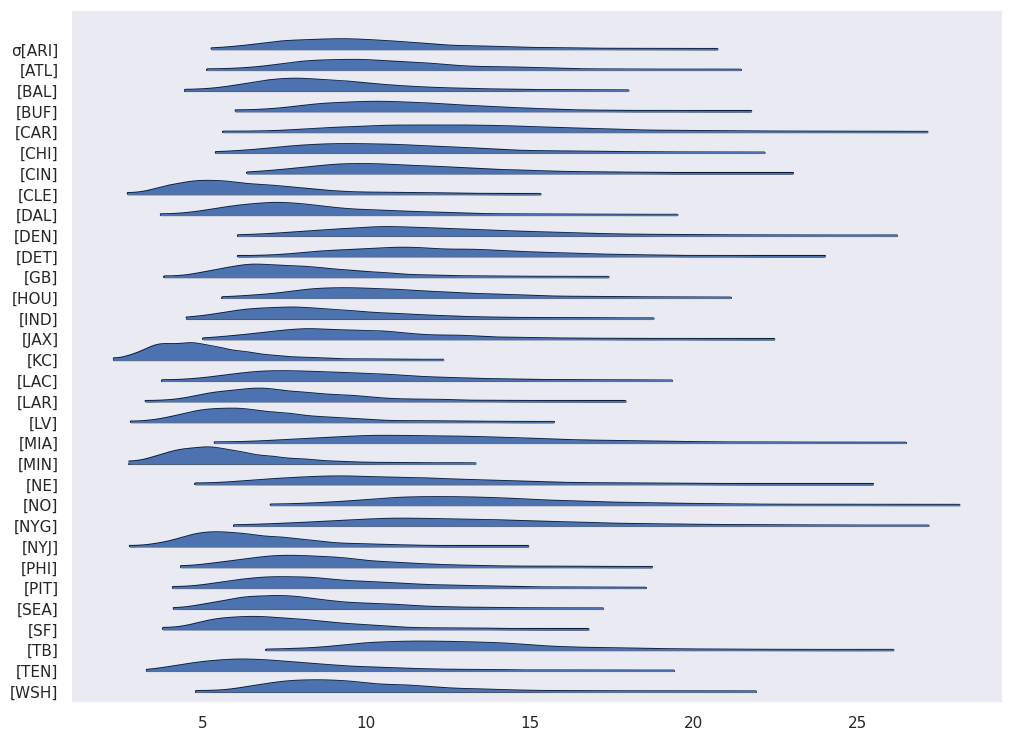

In [10]:
axes = az.plot_forest(idata_nfl, kind="ridgeplot",
                      var_names='σ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)


This mostly looks okay, even if the standard deviations seem to average a little high for nfl teams, it makes some sense since we've only been through 9 weeks. Now for the real test, are the Markov Chains healthy? Let's run a test.

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_mu'}>,
        <Axes: title={'center': 'μ_mu'}>],
       [<Axes: title={'center': 'μ_sd'}>,
        <Axes: title={'center': 'μ_sd'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>],
       [<Axes: title={'center': 'σ_sd'}>,
        <Axes: title={'center': 'σ_sd'}>]], dtype=object)

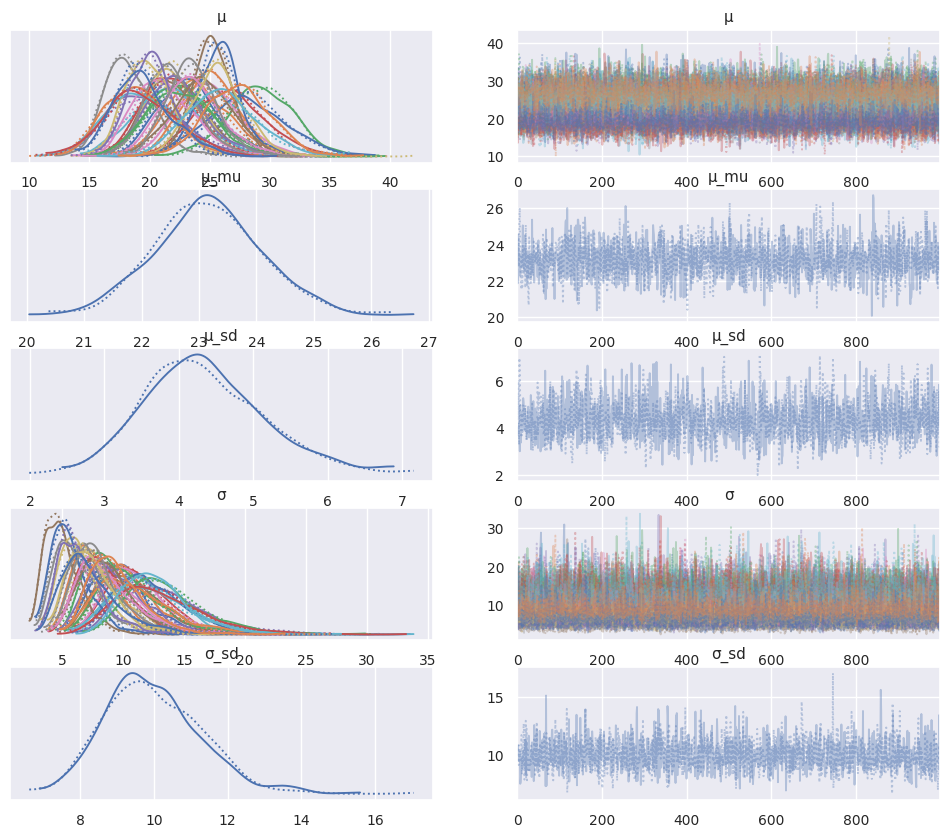

In [11]:
az.plot_trace(idata_nfl)

It looks decent so far, since no chain has fluctuations that deviate from the rest, so the chains seem relatively healthy. Let's try the rhat test.

In [12]:
az.rhat(idata_nfl)

<xarray.Dataset> Size: 920B
Dimensions:  (Team: 32)
Coordinates:
  * Team     (Team) <U3 384B 'ARI' 'ATL' 'BAL' 'BUF' ... 'SF' 'TB' 'TEN' 'WSH'
Data variables:
    μ        (Team) float64 256B 1.001 1.0 1.0 0.9998 ... 1.0 1.004 1.002 1.0
    μ_mu     float64 8B 0.9991
    μ_sd     float64 8B 1.001
    σ        (Team) float64 256B 1.0 1.001 1.0 1.001 ... 1.001 1.003 0.9997 1.0
    σ_sd     float64 8B 0.9993

This is actually perfect and far better than I could have hoped for. Despite most teams only having 8 or 9 data points, they worked well and gave reasonable distributions, likely because of the heaps of data coming in from other teams, for a total of over 270 individual total scores.

Now that we've confirmed our data is good, let's run a posterior predictive check.

In [16]:
pm.sample_posterior_predictive(idata_nfl, model=nfl_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

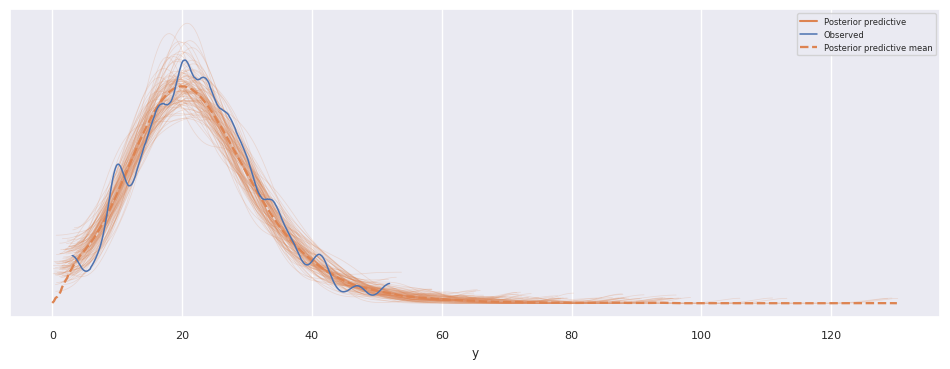

In [18]:
az.plot_ppc(idata_nfl, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

array([<Axes: >], dtype=object)

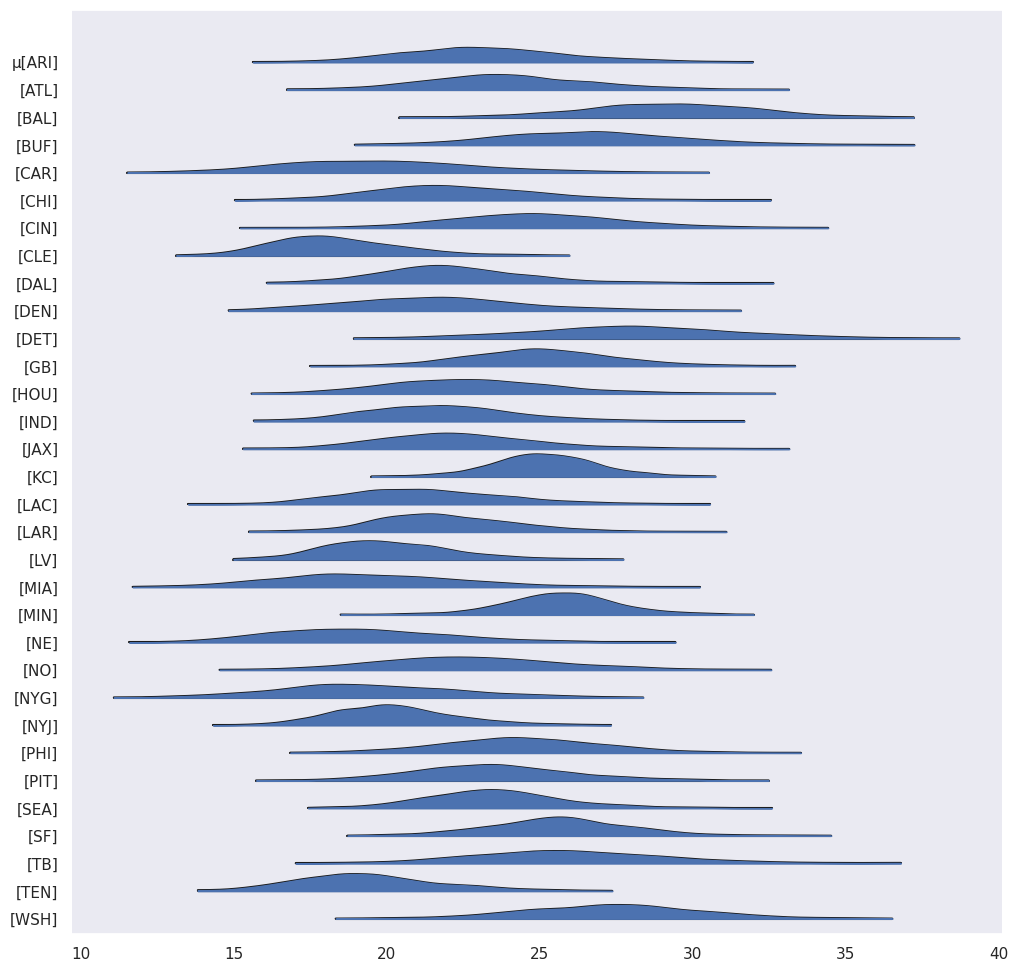

In [22]:
az.plot_forest(idata_nfl, var_names=['μ'], combined=True, figsize=(12, 12), kind = 'ridgeplot', hdi_prob=0.998)

array([<Axes: >], dtype=object)

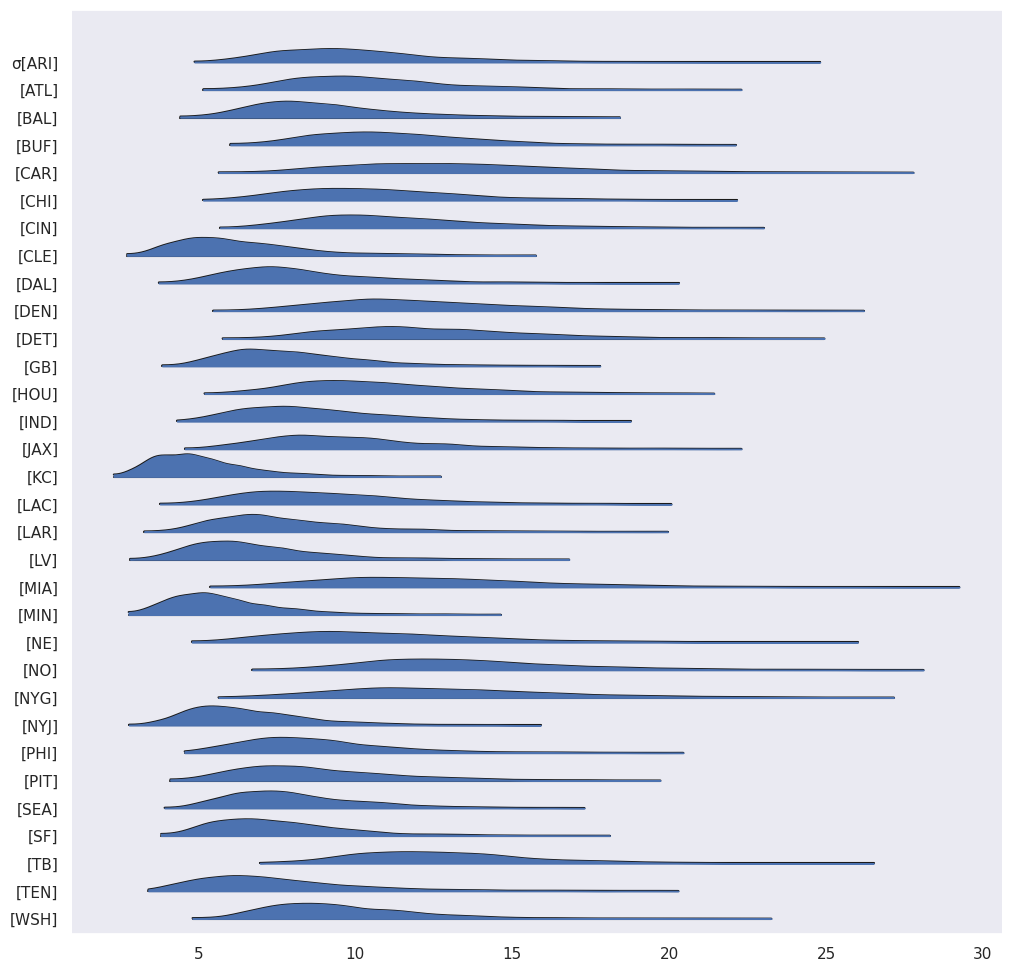

In [25]:
az.plot_forest(idata_nfl, var_names=['σ'], combined=True, figsize=(12, 12), kind = 'ridgeplot', hdi_prob=0.998)

None of these distributions look to be extremely heavily skewed at the HDI endpoints and have roughly the mean and standard deviation values I'd expect for those teams.

##Conclusion
We have a good model! There are no divergencies or weird outliers, and you can clearly see both how good and how consistent each team likely is. I think ultimately the two things it lacks are more data and ideally a posterior predictive check for each individual team, though I'm not entirely sure such a thing exists. All in all, though, the model reflects the NFL season so far in terms of offense, so it's a success.